##### Task: Binary task to classify/predict if a patient is at risk of heart disease

Dataset can be downloaded from: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

Attributes
- Age -  years
- Sex - M:male, F:female
- ChestPainType - [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP - resting blood pressure (mmHg)
- Cholesterol - cholesterol (mm/dl)
- FastingBS - fasting blood sugar [1:fastingBS?120ng/dl, 0: otherwise]
- RestingECG - Normal, ST, LVH
- MaxHR - maximum heart rate
- ExerciseAngina - N:No, Y:yes
- Oldpeak - ST 
- ST_Slope - Up, Flat, Down
- HeartDisease (target) 0: normal,  1: heart disease

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('data/heart.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.shape

(918, 12)

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [7]:
#get numerical and categorical features; if feature has less than 6 unique values --> categorical
categorical_feats=[]
numerical_feats=[]
for col in df.columns:
    if len(df[col].unique())>6:
        numerical_feats.append(col)
    else:
        categorical_feats.append(col)
   
print(f'Categorical features: {categorical_feats} \n Numerical features: {numerical_feats}') 


Categorical features: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease'] 
 Numerical features: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']


#### create encoding for categorical features

In [8]:
cols_to_encode=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for col in cols_to_encode:
    le=LabelEncoder()
    df[col]=le.fit_transform(df[col])
   
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


##### plot numerical features distribution

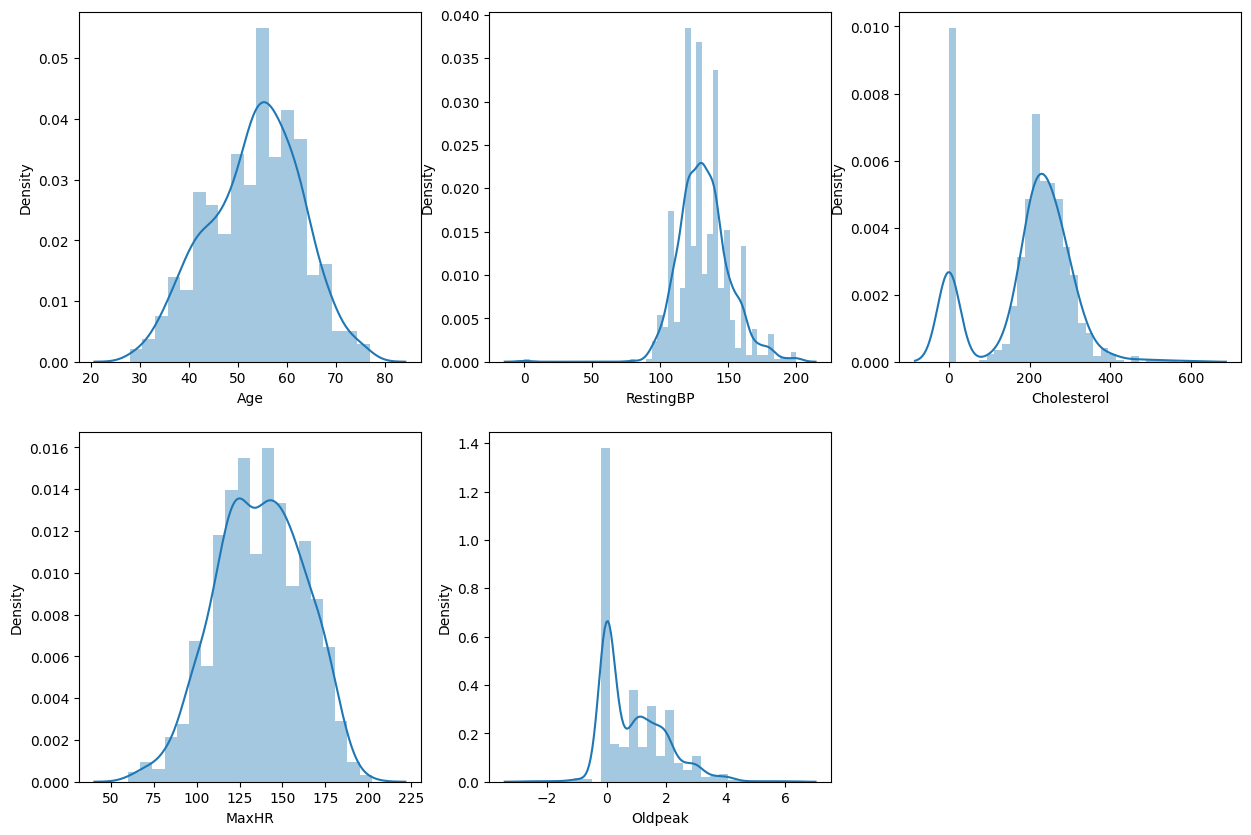

In [9]:

n=len(numerical_feats)
n_cols=3
n_rows=(n+n_cols-1)//n_cols

fig, ax = plt.subplots(nrows = n_rows,ncols = n_cols,figsize = (15,5*n_rows))
ax=ax.flatten()
for i in range(n):
    sns.distplot(df[numerical_feats[i]], ax=ax[i])

for ax in ax[n:]:
    ax.remove()


##### plot categorical features distribution

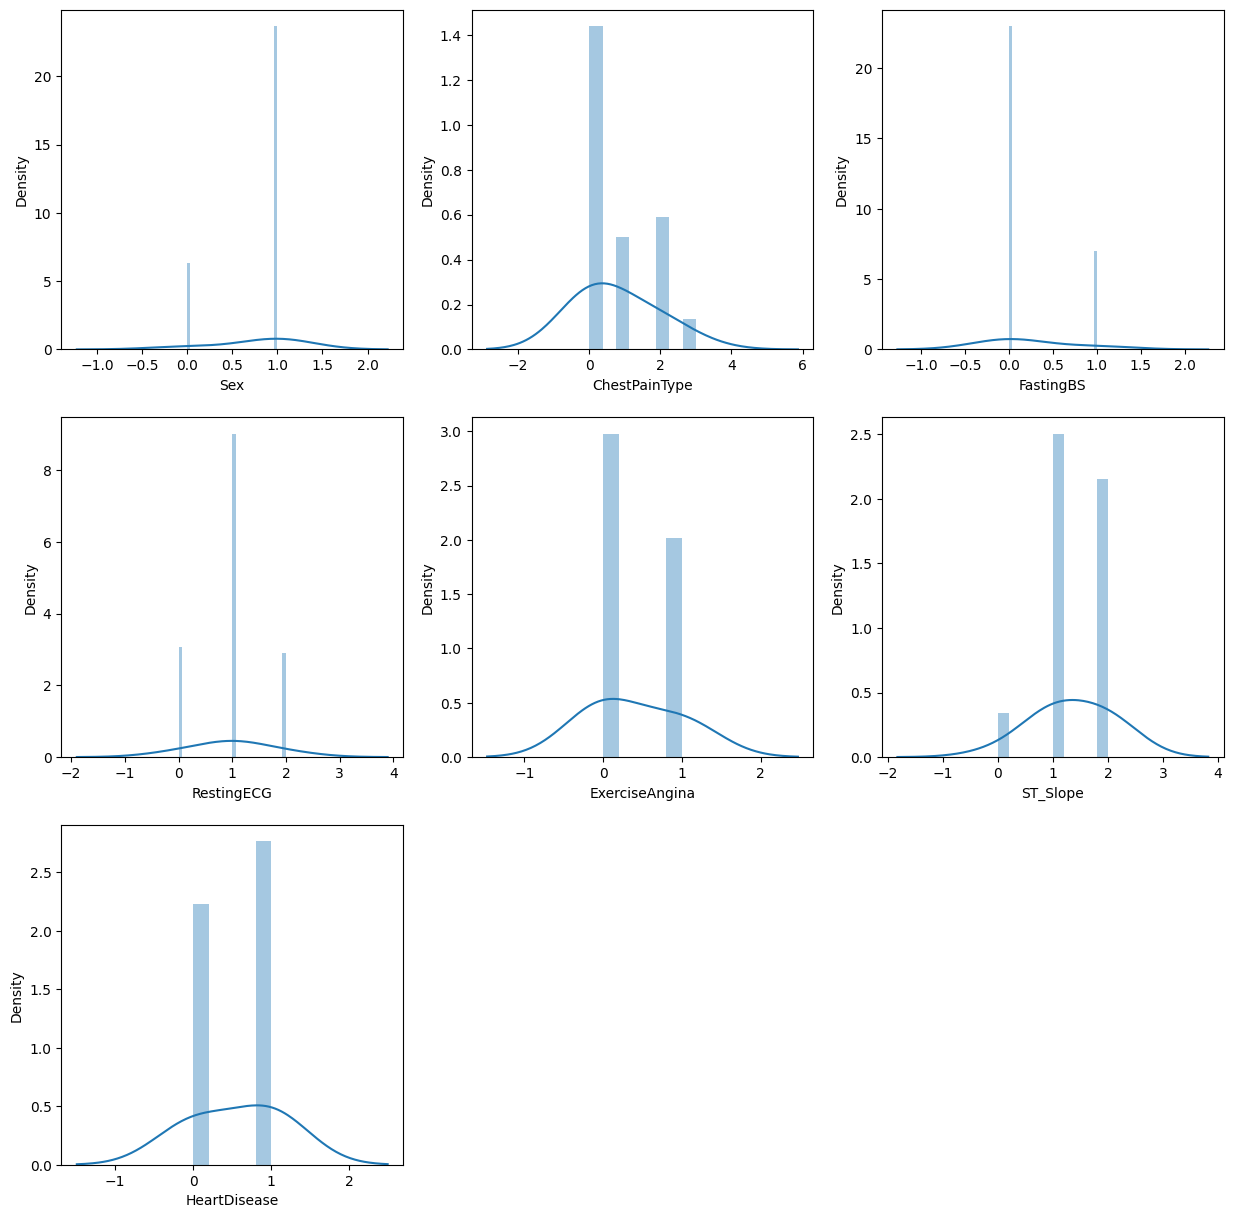

In [10]:
n=len(categorical_feats)
n_cols=3
n_rows=(n+n_cols-1)//n_cols

fig, ax = plt.subplots(nrows = n_rows,ncols = n_cols,figsize = (15,5*n_rows))
ax=ax.flatten()
for i in range(n):
    sns.distplot(df[categorical_feats[i]],kde_kws = {'bw' : 1}, ax=ax[i])

for ax in ax[n:]:
    ax.remove()

##### target variable counts

In [11]:
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

[Text(0.5, 1.0, 'Heart Disease cases'),
 Text(0.5, 0, 'Heart Disease'),
 Text(0, 0.5, 'Count')]

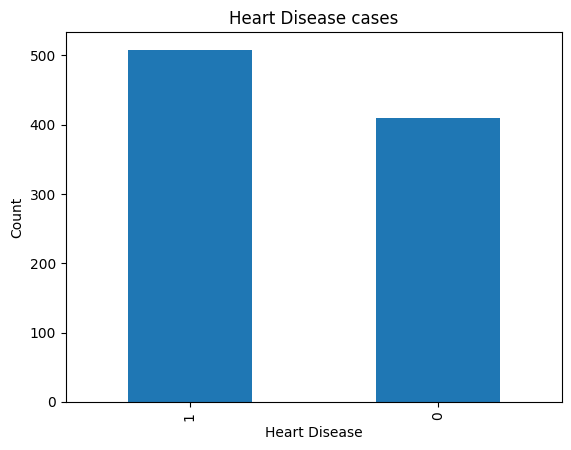

In [12]:
df['HeartDisease'].value_counts().plot(kind='bar').set(title='Heart Disease cases', xlabel='Heart Disease', ylabel='Count')

#### numerical features vs heart disease cases

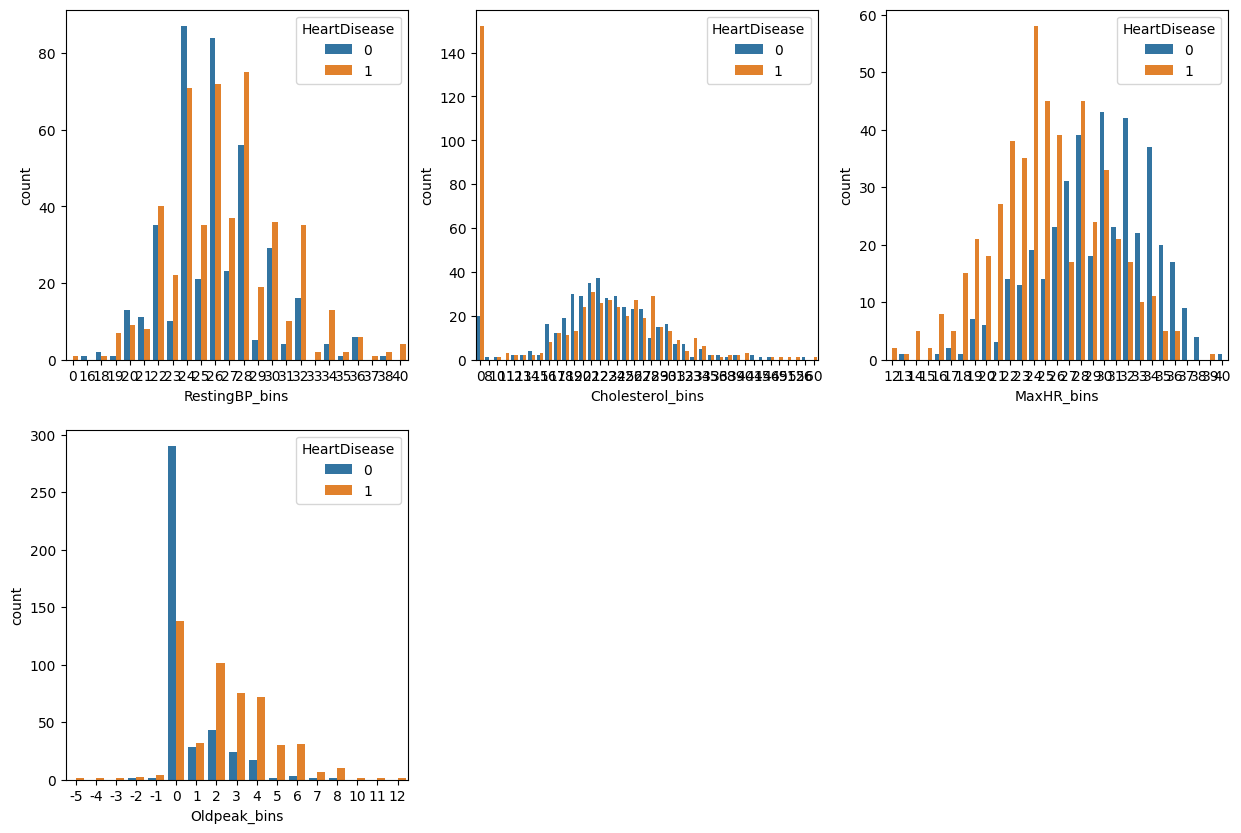

In [13]:

df['RestingBP_bins'] = [ int(i / 5) for i in df['RestingBP']]
df['Cholesterol_bins'] = [ int(i / 10) for i in df['Cholesterol']]
df['MaxHR_bins'] = [ int(i / 5) for i in df['MaxHR']]
df['Oldpeak_bins'] = [ int( (i*10) / 5) for i in df['Oldpeak']]

numerical_feats_bin=[col for col in df.columns if 'bins' in col]

n=len(numerical_feats_bin)
n_cols=3
n_rows=(n+n_cols-1)//n_cols

fig, ax = plt.subplots(nrows = n_rows,ncols = n_cols,figsize = (15,5*n_rows))
ax=ax.flatten()


for i, feature in enumerate(numerical_feats_bin):
    sns.countplot(x=feature, data=df, hue='HeartDisease', ax=ax[i])

for ax in ax[n:]:
    ax.remove()

df=df.drop(columns=numerical_feats_bin)
  

#### categorical features vs heart disease cases

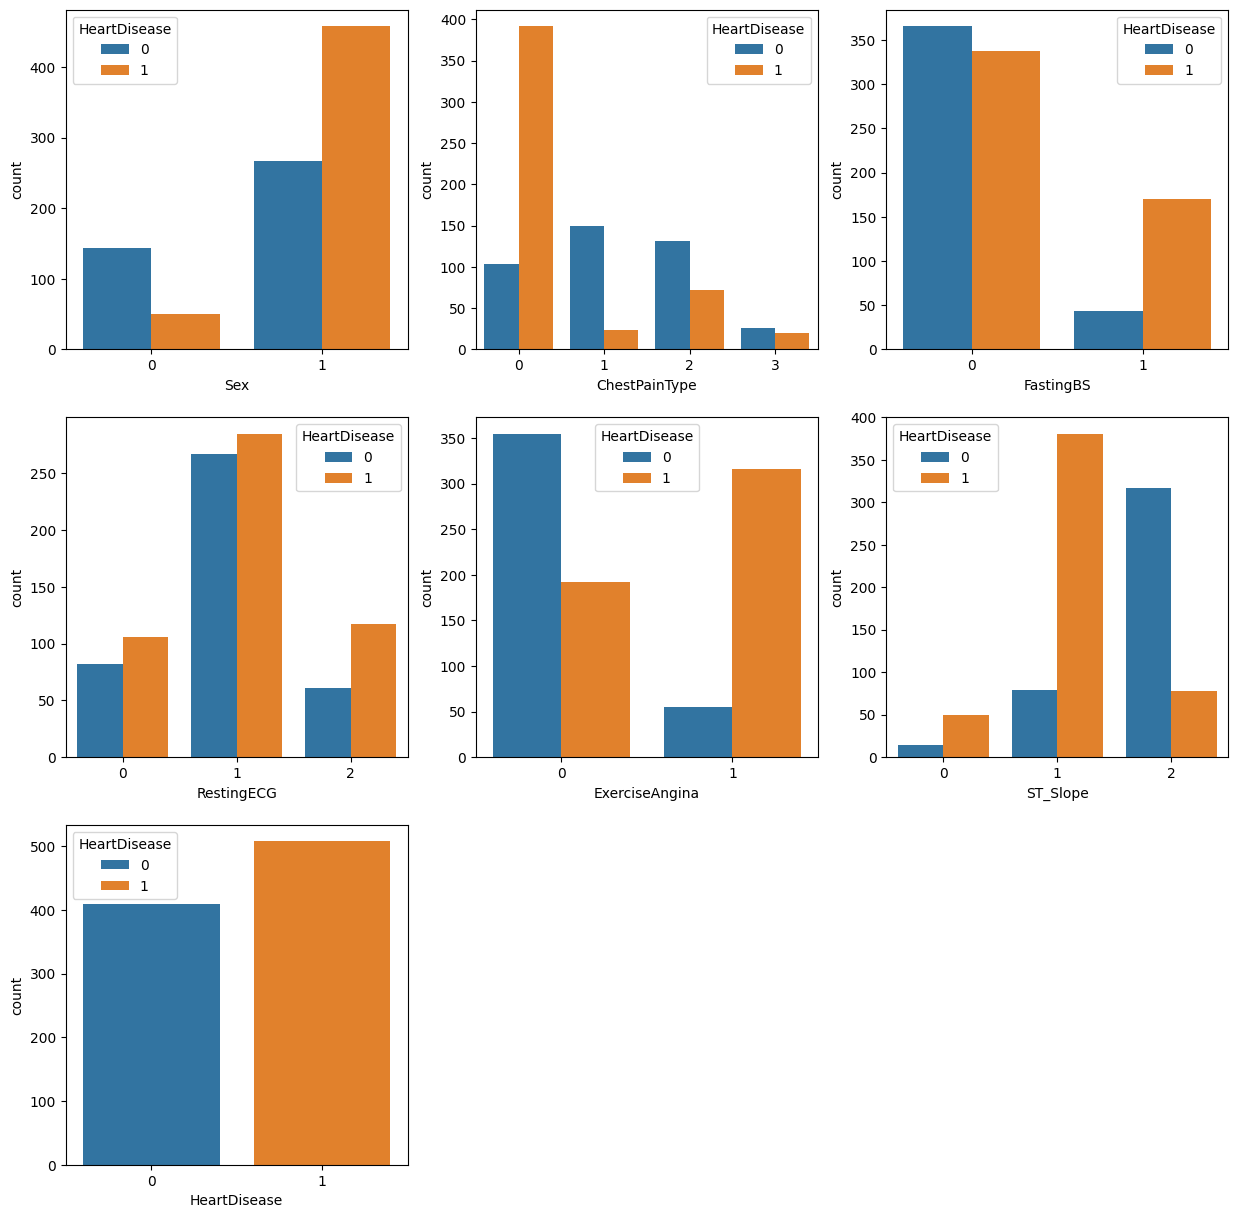

In [14]:
n=len(categorical_feats)
n_cols=3
n_rows=(n+n_cols-1)//n_cols

fig, ax = plt.subplots(nrows = n_rows,ncols = n_cols,figsize = (15,5*n_rows))
ax=ax.flatten()
for i,feature in enumerate(categorical_feats):
    sns.countplot(x=feature, data=df, hue='HeartDisease', ax=ax[i])

for ax in ax[n:]:
    ax.remove()

#### outliers

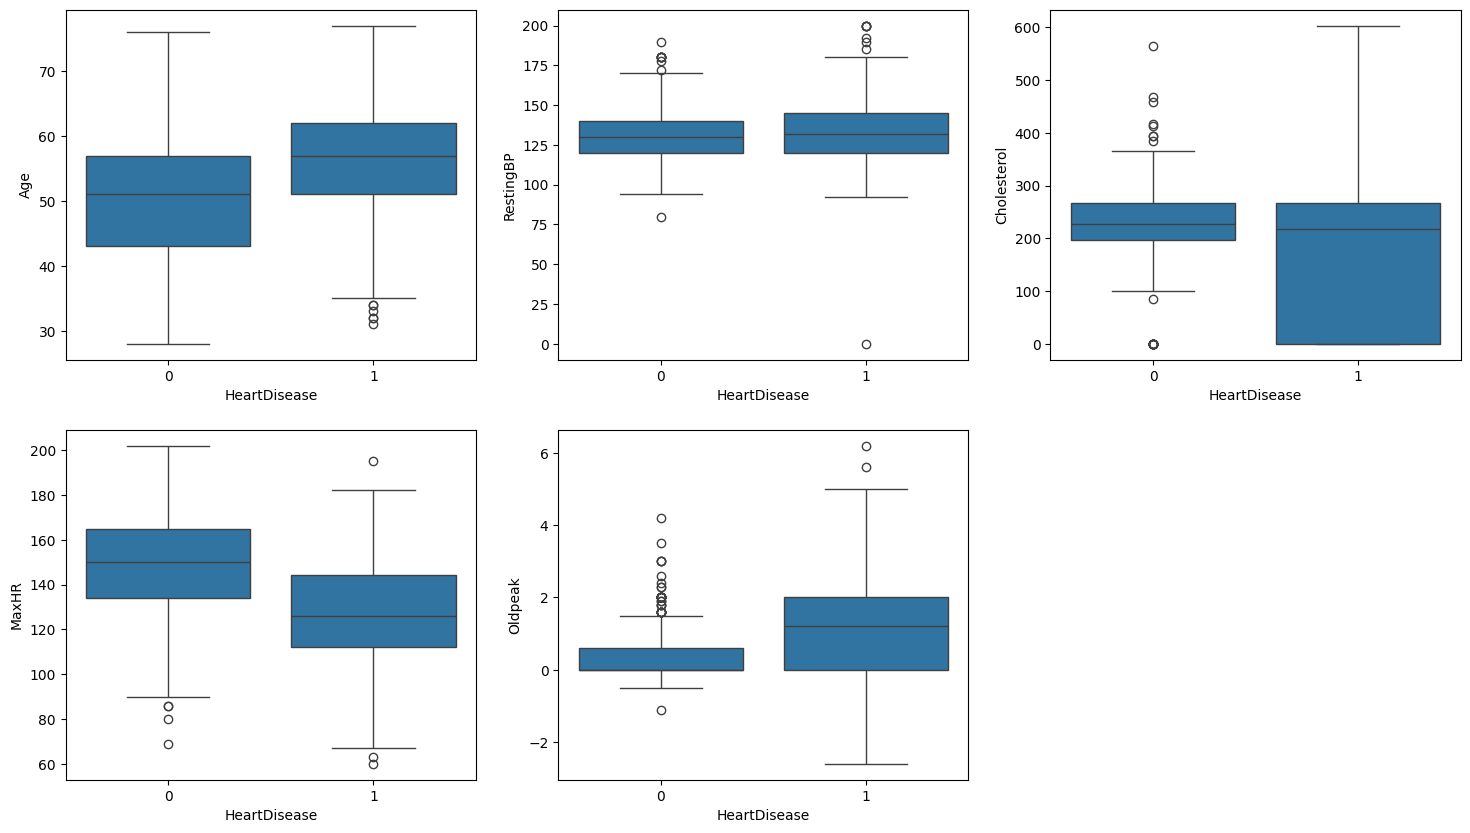

In [15]:
n_cols = 3
n_rows = (len(numerical_feats) + n_cols - 1) // n_cols
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5))

ax = ax.flatten()

for i, feature in enumerate(numerical_feats):
    sns.boxplot(data=df,x='HeartDisease',y=df[feature], ax=ax[i])


for ax in ax[len(numerical_feats):]:
    ax.remove()

#### correlation matrix

<Axes: >

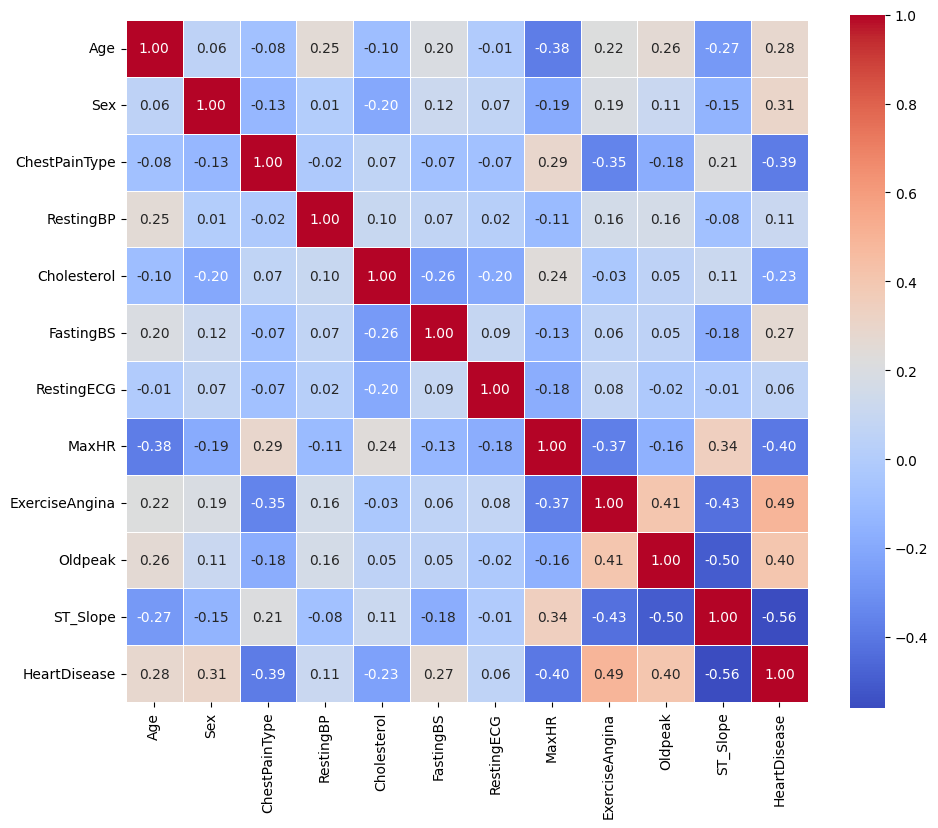

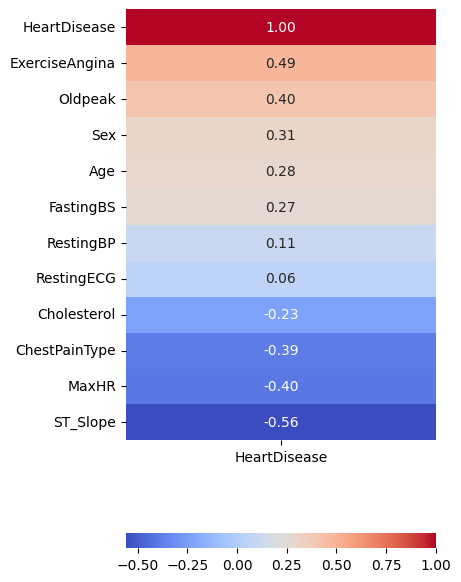

In [16]:
corr = df.corr()
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5)


corr = df.corr()
heart_disease_corr = corr[['HeartDisease']].sort_values(by='HeartDisease', ascending=False)
f, ax = plt.subplots(figsize=(4, 8)) 
sns.heatmap(heart_disease_corr, annot=True, ax=ax, cmap='coolwarm', fmt=".2f", cbar_kws={"orientation": "horizontal"})


##### Models

In [17]:
def classifier_model(model,modelname, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)
    print(f'{modelname} ROC AUC Score: {roc_auc_score(y_test, y_prob[:,1])}')

    
    #plot aucroc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title(modelname)
    plt.plot([0, 1], [0, 1],  lw=2, linestyle='--')


    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues) 
    return


In [18]:
X=df.drop('HeartDisease', axis=1)
y=df['HeartDisease']

X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Logistic Regression ROC AUC Score: 0.9010802281830319


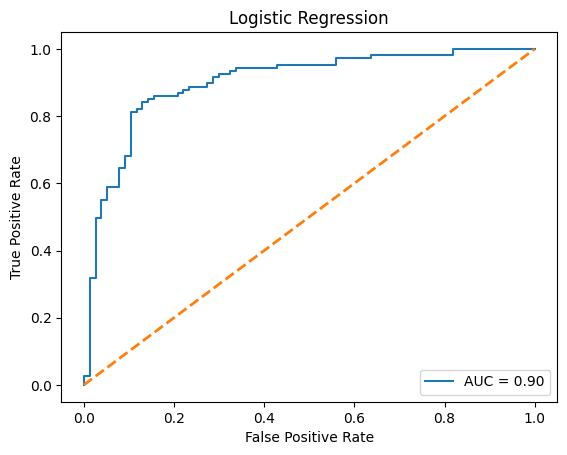

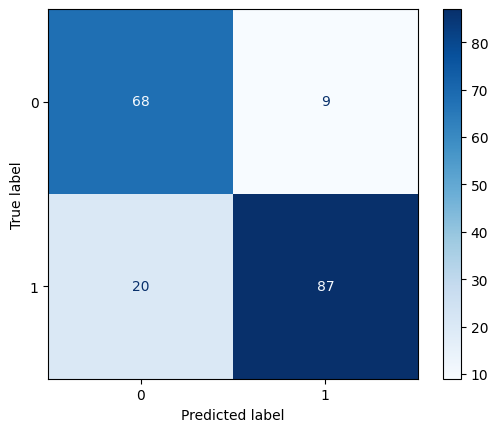

In [19]:
model=LogisticRegression(random_state=10, C=10, penalty='l2')
classifier_model(model,'Logistic Regression', X_train, X_test, y_train, y_test)

Decision Tree ROC AUC Score: 0.9121252579196505


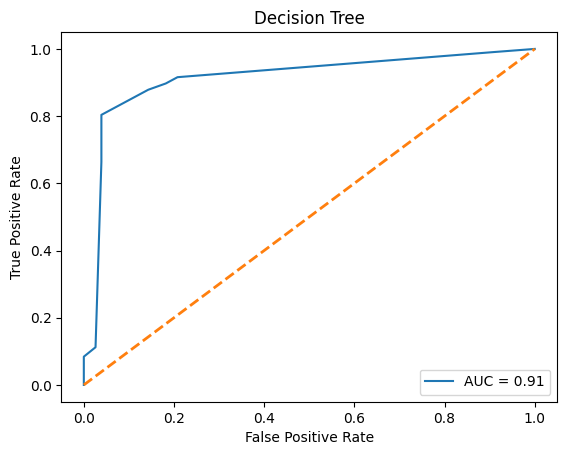

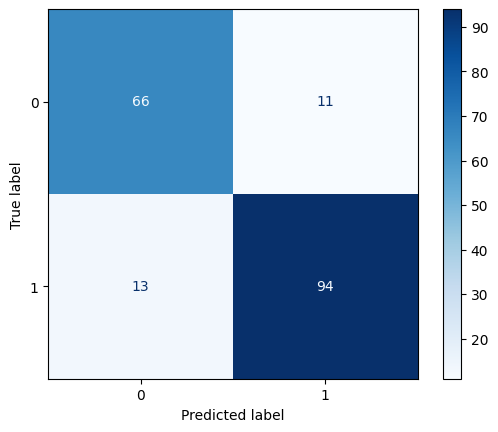

In [20]:
model=DecisionTreeClassifier(random_state=100,max_depth = 4,min_samples_leaf = 1)
classifier_model(model,'Decision Tree', X_train, X_test, y_train, y_test)


Random Forest ROC AUC Score: 0.9351863090180845


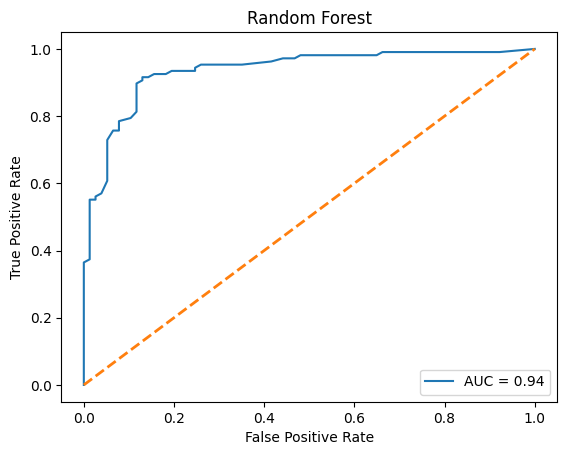

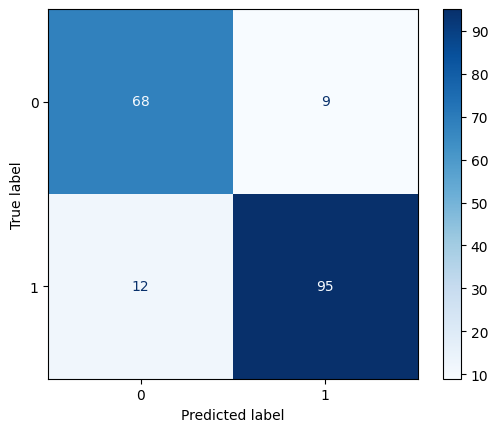

In [21]:
model=RandomForestClassifier(random_state=1000)
classifier_model(model, 'Random Forest',X_train, X_test, y_train, y_test)


KNeighbors ROC AUC Score: 0.9222599830076464


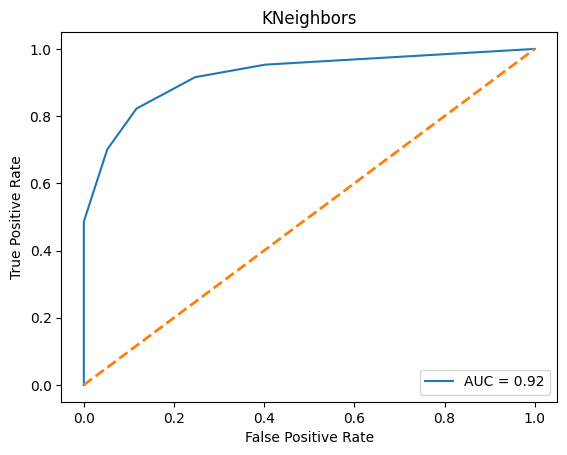

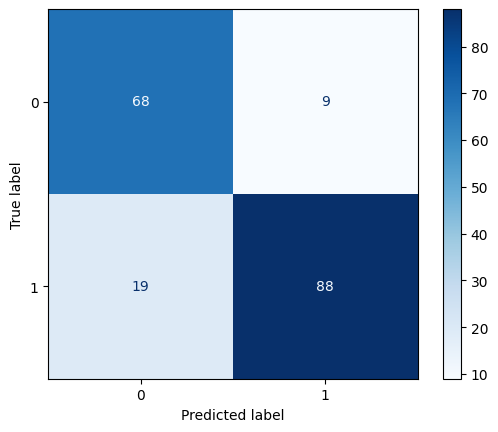

In [22]:
model=KNeighborsClassifier(leaf_size = 2, n_neighbors = 5)
classifier_model(model, 'KNeighbors',  X_train, X_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 401, number of negative: 333
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546322 -> initscore=0.185819
[LightGBM] [Info] Start training from score 0.185819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

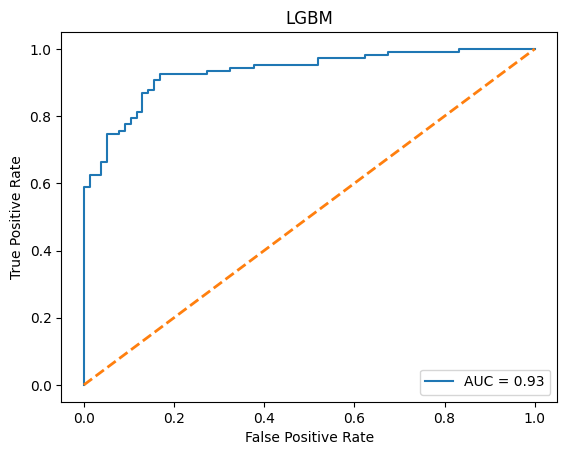

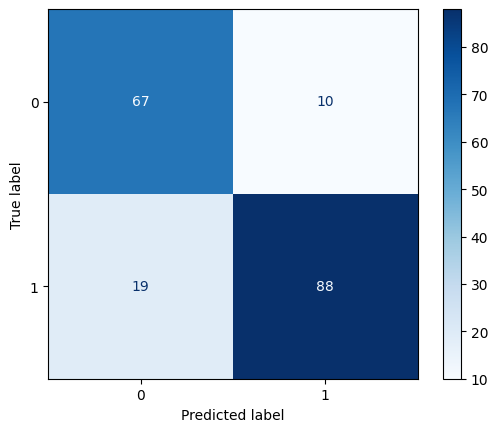

In [23]:
model=LGBMClassifier()
classifier_model(model, 'LGBM', X_train, X_test, y_train, y_test)


XGB ROC AUC Score: 0.9366427964558807


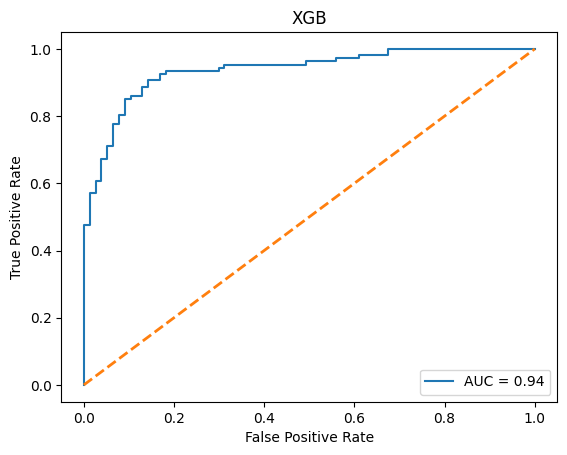

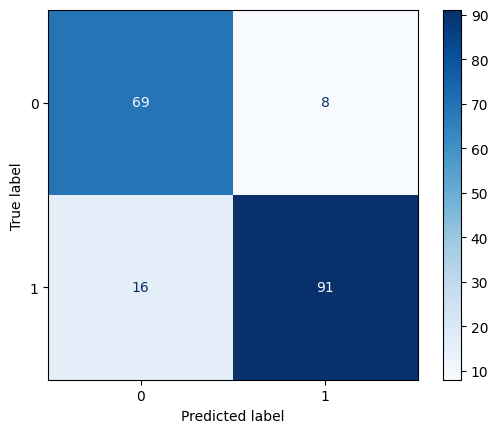

In [24]:
model=XGBClassifier()
classifier_model(model, 'XGB',  X_train, X_test, y_train, y_test)